<a href="https://colab.research.google.com/github/ngocbaosp/ML-Projects/blob/master/Movie_Recomanderation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
import numpy as np

credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies_img.csv')
credits.columns = ['id','tittle','cast','crew']
nRows=11

#https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
from ast import literal_eval
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
  
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

def convertTime(minutes): 
    hour = minutes // 60
    minutes = minutes % 60   
    return "%dh%02d" % (hour, minutes) 
  
def paserData(input):
  
  data = input.copy()
  
  features = ['cast', 'crew', 'keywords', 'genres','production_companies']
  for feature in features:
    data[feature] = data[feature].apply(literal_eval)
    
  data['director'] = data['crew'].apply(get_director)

  features = ['cast', 'keywords', 'genres','production_companies','crew']
  for feature in features:
    data[feature] = data[feature].apply(get_list)
    
        
    
  newData = data  
  return newData

def combineData(credits,movies):
  imageURL='https://image.tmdb.org/t/p/original'
  
  data = pd.merge(movies,credits, how='left', on=['id'])
  
  
  data['imgURL'] = imageURL + movies['poster_path']
  data['runtime'] = data['runtime'].fillna(0)
  data['runtime'] = data['runtime'].astype('int')
  data['score'] = data['vote_average']
  data['release_date'] = data['release_date'].fillna('1900-01-01')
  data['year'] = pd.to_datetime(data['release_date']).dt.year
  data['runtime_str'] = data['runtime'].astype('int').apply(convertTime)
  
  data = paserData(data)
  
  return data




In [20]:
newMoviesData= combineData(credits,movies)
newMoviesData.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,Gore Verbinski
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,/hE24GYddaxB9MVZl1CaiI86M3kp.jpg,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[Thomas Newman, Sam Mendes, Anna Pinnock]",https://image.tmdb.org/t/p/original/hE24GYddax...,6.3,2015,2h28,Sam Mendes
3,250000000,"[Action, Crime, Drama]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist]",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,/dEYnvnUfXrqvqeRSqvIEtmzhoA8.jpg,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]","[Hans Zimmer, Charles Roven, Christopher Nolan]",https://image.tmdb.org/t/p/original/dEYnvnUfXr...,7.6,2012,2h45,Christopher Nolan
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion]",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,/4QDBNt9PmxqUH4Ab2R5xKWqzXiQ.jpg,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]","[Andrew Stanton, Andrew Stanton, John Lasseter]",https://image.tmdb.org/t/p/original/4QDBNt9Pmx...,6.1,2012,2h12,Andrew Stanton


# Demographic Filtering

In [0]:
#https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
#returnColumns = ['id','title','popularity','overview','runtime','poster_path','score','vote_average','vote_count','genres','cast','crew','production_companies','keywords','year']
returnColumns = ['id','title','imgURL','score','popularity']
def demoGraphicFilteringByRatingScore(data,topN=10):
  C = data['vote_average'].mean()
  m= data['vote_count'].quantile(0.9)
  q_movies = data.copy().loc[data['vote_count'] >= m]
  q_movies['score'] = q_movies.apply(weighted_rating,args=(m,C),axis=1)
  
  q_movies = q_movies.sort_values('score', ascending=False)
  
  
  q_movies = q_movies.head(topN)
  
  q_movies = q_movies[returnColumns]
 
  
  return q_movies

In [0]:
def demoGraphicFilteringByPopularity(data,topN=10):
  q_movies = data.copy()
  q_movies = q_movies.sort_values('popularity', ascending=False)
  
  q_movies = q_movies.head(topN)
  
 
  q_movies = q_movies[returnColumns]
  
  return q_movies

In [0]:
demoGraphicFilteringByRatingScore(newMoviesData,11)

,id,title,imgURL,score,popularity
1883,278,The Shawshank Redemption,https://image.tmdb.org/t/p/original/9O7gLzmreU...,8.059855,136.747729
662,550,Fight Club,https://image.tmdb.org/t/p/original/adw6Lq9FiC...,7.939756,146.757391
65,155,The Dark Knight,https://image.tmdb.org/t/p/original/1hRoyzDtpg...,7.920422,187.322927
3234,680,Pulp Fiction,https://image.tmdb.org/t/p/original/dM2w364MSc...,7.905182,121.463076
96,27205,Inception,https://image.tmdb.org/t/p/original/qmDpIHrmpJ...,7.863584,167.583710
3339,238,The Godfather,https://image.tmdb.org/t/p/original/rPdtLWNsZm...,7.851927,143.659698
95,157336,Interstellar,https://image.tmdb.org/t/p/original/nBNZadXqJS...,7.809888,724.247784
809,13,Forrest Gump,https://image.tmdb.org/t/p/original/yE5d3BUhE8...,7.803718,138.133331
329,122,The Lord of the Rings: The Return of the King,https://image.tmdb.org/t/p/original/uexxR7Kw1q...,7.727742,123.630332
1992,1891,The Empire Strikes Back,https://image.tmdb.org/t/p/original/6u1fYtxG5e...,7.698512,78.517830


In [0]:
demoGraphicFilteringByPopularity(newMoviesData,11)

,id,title,imgURL,score,popularity
546,211672,Minions,https://image.tmdb.org/t/p/original/q0R4crx2Se...,6.4,875.581305
95,157336,Interstellar,https://image.tmdb.org/t/p/original/nBNZadXqJS...,8.1,724.247784
788,293660,Deadpool,https://image.tmdb.org/t/p/original/inVq3FRqcY...,7.4,514.569956
94,118340,Guardians of the Galaxy,https://image.tmdb.org/t/p/original/y31QB9kn3X...,7.9,481.098624
127,76341,Mad Max: Fury Road,https://image.tmdb.org/t/p/original/kqjL17yufv...,7.2,434.278564
28,135397,Jurassic World,https://image.tmdb.org/t/p/original/jjBgi2r5cR...,6.5,418.708552
199,22,Pirates of the Caribbean: The Curse of the Bla...,https://image.tmdb.org/t/p/original/tkt9xR1kNX...,7.5,271.972889
82,119450,Dawn of the Planet of the Apes,https://image.tmdb.org/t/p/original/2EUAUIu5lH...,7.3,243.791743
200,131631,The Hunger Games: Mockingjay - Part 1,https://image.tmdb.org/t/p/original/gj282Pniaa...,6.6,206.227151
88,177572,Big Hero 6,https://image.tmdb.org/t/p/original/9gLu47Zw5e...,7.8,203.734590


# Content Based Filtering

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
cbData = newMoviesData.copy()
cbData.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,Gore Verbinski


In [0]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [0]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres','production_companies']

for feature in features:
    cbData[feature] = cbData[feature].apply(clean_data)

In [0]:
cbData.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[ingeniousfilmpartners, twentiethcenturyfoxfil...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,jamescameron
1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[waltdisneypictures, jerrybruckheimerfilms, se...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,goreverbinski


In [0]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])#+ ' '.join(x['production_companies'])
  
  
cbData['soup'] = cbData.apply(create_soup, axis=1)

cbData.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director,soup
0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[ingeniousfilmpartners, twentiethcenturyfoxfil...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,jamescameron,cultureclash future spacewar samworthington zo...
1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[waltdisneypictures, jerrybruckheimerfilms, se...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,goreverbinski,ocean drugabuse exoticisland johnnydepp orland...


In [0]:
# Import CountVectorizer and create the count matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(cbData['soup'])

In [0]:
count_matrix

<4807x11520 sparse matrix of type '<class 'numpy.int64'>'
	with 42975 stored elements in Compressed Sparse Row format>

In [0]:
# Compute the Cosine Similarity matrix based on the count_matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [0]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(inputData,title, cosine_sim,topN):
  
    data = inputData.copy()
  
    #Construct a reverse map of indices and movie titles
    indices = pd.Series(data.index, index=data['title']).drop_duplicates()

    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:topN]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data.iloc[movie_indices]#data['title'].iloc[movie_indices]

In [0]:
cbResult = get_recommendations(cbData,'The Dark Knight Rises',cosine_sim2,12)
cbResult[returnColumns]

,id,title,imgURL,score,popularity
65,155,The Dark Knight,https://image.tmdb.org/t/p/original/1hRoyzDtpg...,8.2,187.322927
119,272,Batman Begins,https://image.tmdb.org/t/p/original/dr6x4Gyyeg...,7.5,115.040024
4642,378237,Amidst the Devil's Wings,NaN,0.0,0.018087
1196,1124,The Prestige,https://image.tmdb.org/t/p/original/5MXyQfz8xU...,8.0,74.440708
3075,2088,Romeo Is Bleeding,https://image.tmdb.org/t/p/original/bb8Gtk8WlX...,5.7,4.850402
3328,312113,Black November,https://image.tmdb.org/t/p/original/gOZGwibxEV...,6.4,1.589693
1503,22907,Takers,https://image.tmdb.org/t/p/original/zwepORN3ON...,6.0,18.472420
1988,41283,Faster,https://image.tmdb.org/t/p/original/xaHojTGfid...,6.1,26.324874
303,314,Catwoman,https://image.tmdb.org/t/p/original/3E1XPZ2lZm...,4.2,32.271938
747,82682,Gangster Squad,https://image.tmdb.org/t/p/original/qutxlK5ggp...,6.2,29.041198


In [0]:
oldRatings = pd.read_csv('ratings_small.csv')
userRatings = pd.read_csv('user_rating.csv')
ratings = oldRatings.append(userRatings)
userRatings

,userId,movieId,rating,timestamp
0,1,49026,9.0,1.565061e+09
1,2,120,87.0,1.565067e+09
2,2,7870,86.7,1.565067e+09
3,2,1891,88.9,1.565068e+09
4,2,122,87.0,1.565068e+09
5,2,13,85.5,1.565068e+09
6,2,550,86.7,1.565068e+09
7,2,60308,83.3,1.565068e+09
8,2,680,94.2,1.565068e+09
9,2,1891,84.5,1.565068e+09


In [0]:
oldRatings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [0]:
ratings.info()
ratings.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100031 entries, 0 to 26
Data columns (total 4 columns):
userId       100031 non-null int64
movieId      100031 non-null int64
rating       100031 non-null float64
timestamp    100031 non-null float64
dtypes: float64(2), int64(2)
memory usage: 3.8 MB


,userId,movieId,rating,timestamp
22,2,40794,70.0,1.565101e+09
23,2,155,56.3,1.565101e+09
24,2,120,62.2,1.565101e+09
25,2,680,83.1,1.565101e+09
26,2,4551,76.9,1.565101e+09


In [0]:
def getLatestMovieByUserId(ratingData,moviesData,userId):
  df = ratingData.copy()
  df = ratingData[ratingData['userId']==userId]
  df = df.sort_values('timestamp', ascending=False)
  df.columns=['userId','id','rating','timestamp']
  data = pd.merge(df,moviesData, how='left', on=['id'])
  print(data[['id','original_title']])
  data = data.dropna(subset=['original_title'])
  print(data[['id','original_title']])
  
  
  title = data.head(1)

  return title['original_title'].item()

In [0]:
getLatestMovieByUserId(ratings,newMoviesData,2)

        id                                     original_title
0     4551                                            Be Cool
1      680                                       Pulp Fiction
2      120  The Lord of the Rings: The Fellowship of the Ring
3      155                                    The Dark Knight
4    40794                                       Mine vaganti
5    44857                                              Molly
6       13                                       Forrest Gump
7      120  The Lord of the Rings: The Fellowship of the Ring
8     1891                            The Empire Strikes Back
9     1429                                          25th Hour
10     278                           The Shawshank Redemption
11   79698                                         The Lovers
12     680                                       Pulp Fiction
13   24746                                 Six-String Samurai
14    1894       Star Wars: Episode II - Attack of the Clones
15      

'Be Cool'

# Get Video Info

In [0]:
def getFilmInfo(data,id):
  return data[data['id'] == id]

getFilmInfo(newMoviesData,6071)

  

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
1253,40000000,"[Action, Crime, Drama]",NaN,6071,[hoodlum],en,Kiss of Death,Jimmy Kilmartin is an ex-con living in Astoria...,6.90894,[Twentieth Century Fox Film Corporation],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-04-21,0,101,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Kiss of Death,5.7,81,/uQjFpAEF6GUIKW46sbndWtsEQSl.jpg,Kiss of Death,"[David Caruso, Samuel L. Jackson, Nicolas Cage]","[Lee Percy, Richard Price, Trevor Jones]",https://image.tmdb.org/t/p/original/uQjFpAEF6G...,5.7,1995,1h41,Barbet Schroeder


In [0]:
userId
movieId = 49026	

uRating = ratings[ratings['userId']== userId]

uRating = uRating[uRating['movieId']== movieId]
uRating
if(uRating['rating'].count()>0):
  r = uRating['rating'].item()
else:
  r = 0
r


9.0

In [0]:
def getRatingByUser(userId,movieId):

    print(ratings)
    print(userId)

    print(movieId)

    uRating = ratings[ratings['userId'] == userId]

    print(uRating)

    uRating = uRating[uRating['movieId'] == movieId]


    print(uRating)


    if (uRating['rating'].count() > 0):
        r = uRating['rating'].item()
    else:
        r = 0

    print(r)
    return r

In [0]:
getRatingByUser(1,49026)

        userId  movieId  rating     timestamp
0            1       31     2.5  1.260759e+09
1            1     1029     3.0  1.260759e+09
2            1     1061     3.0  1.260759e+09
3            1     1129     2.0  1.260759e+09
4            1     1172     4.0  1.260759e+09
5            1     1263     2.0  1.260759e+09
6            1     1287     2.0  1.260759e+09
7            1     1293     2.0  1.260759e+09
8            1     1339     3.5  1.260759e+09
9            1     1343     2.0  1.260759e+09
10           1     1371     2.5  1.260759e+09
11           1     1405     1.0  1.260759e+09
12           1     1953     4.0  1.260759e+09
13           1     2105     4.0  1.260759e+09
14           1     2150     3.0  1.260759e+09
15           1     2193     2.0  1.260759e+09
16           1     2294     2.0  1.260759e+09
17           1     2455     2.5  1.260759e+09
18           1     2968     1.0  1.260759e+09
19           1     3671     3.0  1.260759e+09
20           2       10     4.0  8

9.0

In [0]:
userId
movieId = 1029

uRating = ratings[ratings['userId']== userId]
uRating

,userId,movieId,rating,timestamp
0,1,31,2.5,1.260759e+09
1,1,1029,3.0,1.260759e+09
2,1,1061,3.0,1.260759e+09
3,1,1129,2.0,1.260759e+09
4,1,1172,4.0,1.260759e+09
5,1,1263,2.0,1.260759e+09
6,1,1287,2.0,1.260759e+09
7,1,1293,2.0,1.260759e+09
8,1,1339,3.5,1.260759e+09
9,1,1343,2.0,1.260759e+09


# Collaboration Filtering

In [0]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [0]:
pip install scikit-surprise

     |████████████████████████████████| 3.3MB 8.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.0.6-cp36-cp36m-linux_x86_64.whl size=1683502 sha256=49c8f1e6b12df5752b24a6c353933be1192959ad35bd338b5d4c4a8da7c75c00
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 1.5428
MAE:  0.7143
------------
Fold 2
RMSE: 1.6224
MAE:  0.7133
------------
Fold 3
RMSE: 1.4753
MAE:  0.7066
------------
Fold 4
RMSE: 1.6377
MAE:  0.7155
------------
Fold 5
RMSE: 1.4704
MAE:  0.7054
------------
------------
Mean RMSE: 1.5497
Mean MAE : 0.7110
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7142933024983502,
                             0.71330979200509,
                             0.7066117529946035,
                             0.7154552040078344,
                             0.7054347064919042],
                            'rmse': [1.5427810980889916,
                             1.622425470242418,
                             1.4752626932777935,
                             1.6376665556913113,
                             1.4703810502877217]})

In [0]:
trainset = data.build_full_trainset()
svd.train(trainset)

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [0]:
svd.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=3.0819477390255425, details={'was_impossible': False})

In [0]:
svd.predict(1, 4444444444, 5555)

Prediction(uid=1, iid=4444444444, r_ui=5555, est=2.881609138273888, details={'was_impossible': False})

In [0]:
userId= 1
svd.predict(userId, 4444444444)

Prediction(uid=1, iid=4444444444, r_ui=None, est=2.881609138273888, details={'was_impossible': False})

In [0]:
ratingData = ratings[ratings['userId']!=userId]
movieId = ratingData['movieId']
movieIndice = movieId.unique()
movieIndice


array([   10,    17,    39, ..., 44857, 40794,  4551])

In [0]:
moviesCF = newMoviesData.loc[newMoviesData['id'].isin(movieIndice)]
moviesCF.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,Gore Verbinski
5,258000000,"[Fantasy, Action, Adventure]",http://www.sonypictures.com/movies/spider-man3/,559,"[dual identity, amnesia, sandstorm]",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[Columbia Pictures, Laura Ziskin Productions, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,/sqZKCRYGovZ8aN99VVJSdL8Ja9k.jpg,Spider-Man 3,"[Tobey Maguire, Kirsten Dunst, James Franco]","[Francine Maisler, Joseph M. Caracciolo Jr., S...",https://image.tmdb.org/t/p/original/sqZKCRYGov...,5.9,2007,2h19,Sam Raimi
8,250000000,"[Adventure, Fantasy, Family]",http://harrypotter.warnerbros.com/harrypottera...,767,"[witch, magic, broom]",en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[Warner Bros., Heyday Films]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2009-07-07,933959197,153,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,/bFXys2nhALwDvpkF3dP3Vvdfn8b.jpg,Harry Potter and the Half-Blood Prince,"[Daniel Radcliffe, Rupert Grint, Emma Watson]","[Bruno Delbonnel, Stephanie McMillan, Stuart C...",https://image.tmdb.org/t/p/original/bFXys2nhAL...,7.4,2009,2h33,David Yates


In [0]:
moviesCF['est']=moviesCF['id'].apply(lambda x: svd.predict(userId, x).est)
moviesCF = moviesCF.sort_values('est', ascending=False)
moviesCF.head(2)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director,est
1992,18000000,"[Adventure, Action, Science Fiction]",http://www.starwars.com/films/star-wars-episod...,1891,"[rebel, android, asteroid]",en,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",78.517830,"[Lucasfilm, Twentieth Century Fox Film Corpora...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1980-05-17,538400000,124,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Adventure Continues...,The Empire Strikes Back,8.2,5879,/6u1fYtxG5eqjhtCPDx04pJphQRW.jpg,The Empire Strikes Back,"[Mark Hamill, Harrison Ford, Carrie Fisher]","[George Lucas, George Lucas, George Lucas]",https://image.tmdb.org/t/p/original/6u1fYtxG5e...,8.2,1980,2h04,Irvin Kershner,5.00000
3234,8000000,"[Thriller, Crime]",NaN,680,"[transporter, brothel, drug dealer]",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[Miramax Films, A Band Apart, Jersey Films]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-10-08,213928762,154,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8428,/dM2w364MScsjFf8pfMbaWUcWrR.jpg,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman]","[Quentin Tarantino, Quentin Tarantino, Lawrenc...",https://image.tmdb.org/t/p/original/dM2w364MSc...,8.3,1994,2h34,Quentin Tarantino,4.99555


In [0]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])
trainset = data.build_full_trainset()
svd.train(trainset)

/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 1.2924
MAE:  0.7078
------------
Fold 2
RMSE: 1.4651
MAE:  0.7134
------------
Fold 3
RMSE: 1.8641
MAE:  0.7191
------------
Fold 4
RMSE: 1.4390
MAE:  0.7044
------------
Fold 5
RMSE: 1.6380
MAE:  0.7162
------------
------------
Mean RMSE: 1.5397
Mean MAE : 0.7122
------------
------------


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [0]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()





def collaborationFiltering(ratings,newMoviesData,userId):
  
  
  ratingData = ratings[ratings['userId']!=userId]
  movieId = ratingData['movieId']
  movieIndice = movieId.unique()
  movieIndice

  moviesCF = newMoviesData.loc[newMoviesData['id'].isin(movieIndice)]
  #moviesCF.head(3)

  moviesCF['est']=moviesCF['id'].apply(lambda x: svd.predict(userId, x).est)
  moviesCF = moviesCF.sort_values('est', ascending=False)
  #moviesCF.head(2)
  
  return moviesCF

In [0]:
collaborationFiltering(ratings,newMoviesData,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director,est
262,93000000,"[Adventure, Fantasy, Action]",http://www.lordoftherings.net/,120,"[elves, dwarves, orcs]",en,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...",138.049577,"[WingNut Films, New Line Cinema, The Saul Zaen...","[{""iso_3166_1"": ""NZ"", ""name"": ""New Zealand""}, ...",2001-12-18,871368364,178,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,One ring to rule them all,The Lord of the Rings: The Fellowship of the Ring,8.0,8705,/bxVxZb5O9OxCO0oRUNdCnpy9NST.jpg,The Lord of the Rings: The Fellowship of the Ring,"[Elijah Wood, Ian McKellen, Cate Blanchett]","[Barrie M. Osborne, Howard Shore, Peter Jackson]",https://image.tmdb.org/t/p/original/bxVxZb5O9O...,8.0,2001,2h58,Peter Jackson,4.991204
1992,18000000,"[Adventure, Action, Science Fiction]",http://www.starwars.com/films/star-wars-episod...,1891,"[rebel, android, asteroid]",en,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",78.517830,"[Lucasfilm, Twentieth Century Fox Film Corpora...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1980-05-17,538400000,124,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Adventure Continues...,The Empire Strikes Back,8.2,5879,/6u1fYtxG5eqjhtCPDx04pJphQRW.jpg,The Empire Strikes Back,"[Mark Hamill, Harrison Ford, Carrie Fisher]","[George Lucas, George Lucas, George Lucas]",https://image.tmdb.org/t/p/original/6u1fYtxG5e...,8.2,1980,2h04,Irvin Kershner,4.835670
3234,8000000,"[Thriller, Crime]",NaN,680,"[transporter, brothel, drug dealer]",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[Miramax Films, A Band Apart, Jersey Films]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-10-08,213928762,154,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8428,/dM2w364MScsjFf8pfMbaWUcWrR.jpg,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman]","[Quentin Tarantino, Quentin Tarantino, Lawrenc...",https://image.tmdb.org/t/p/original/dM2w364MSc...,8.3,1994,2h34,Quentin Tarantino,4.712886
809,55000000,"[Comedy, Drama, Romance]",NaN,13,"[vietnam veteran, hippie, mentally disabled]",en,Forrest Gump,A man with a low IQ has accomplished great thi...,138.133331,[Paramount Pictures],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,677945399,142,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,7927,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise]","[Alan Silvestri, Robert Zemeckis, Winston Groom]",https://image.tmdb.org/t/p/original/yE5d3BUhE8...,8.2,1994,2h22,Robert Zemeckis,4.295844
2914,11000000,"[Adventure, Action, Science Fiction]",http://www.starwars.com/films/star-wars-episod...,11,"[android, galaxy, hermit]",en,Star Wars,Princess Leia is captured and held hostage by ...,126.393695,"[Lucasfilm, Twentieth Century Fox Film Corpora...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,775398007,121,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,6624,/btTdmkgIvOi0FFip1sPuZI2oQG6.jpg,Star Wars,"[Mark Hamill, Harrison Ford, Carrie Fisher]","[George Lucas, George Lucas, George Lucas]",https://image.tmdb.org/t/p/original/btTdmkgIvO...,8.1,1977,2h01,George Lucas,4.136927
3285,8000000,"[Drama, Romance]",http://www.downinthevalleyfilm.com/main.htm,7870,"[indian territory, beach, stetson]",en,Down in the Valley,"On a trip to the beach, a teenage girl named T...",7.433574,[Class 5 Films],"[{""is

In [0]:
newMoviesData.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,Gore Verbinski


In [67]:
newMoviesData[newMoviesData['title'].str.contains('ava',case=False,na=False, regex=False)]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,James Cameron
960,50000000,"[Adventure, Family, Science Fiction]",http://www.miramax.com/movie/the-adventures-of...,14199,"[imaginary friend, outcast]",en,The Adventures of Sharkboy and Lavagirl,Everyone always knew that Max had a wild imagi...,12.311010,[Troublemaker Studios],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-06-10,69425966,92,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Smaller heroes. Just as super.,The Adventures of Sharkboy and Lavagirl,4.4,269,/wRwwPkulIpViuq6DsrPabb30lCD.jpg,The Adventures of Sharkboy and Lavagirl,"[Taylor Lautner, Taylor Dooley, Cayden Boyd]","[Robert Rodriguez, Robert Rodriguez, Robert Ro...",https://image.tmdb.org/t/p/original/wRwwPkulIp...,4.4,2005,1h32,Robert Rodriguez
1075,45000000,"[Crime, Drama, Thriller]",http://www.savagesfilm.com/,82525,"[widow, american abroad, eye gouging]",en,Savages,Pot growers Ben and Chon face off against the ...,31.856589,"[Ixtlan, Relativity Media, Onda Entertainment]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-06,82966152,131,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Young Beautiful Deadly.,Savages,6.2,766,/ecN4PGSU6zhYlAUL8Jh4qyE2um9.jpg,Savages,"[Blake Lively, Taylor Kitsch, Aaron Taylor-Joh...","[Oliver Stone, Oliver Stone, Sarah Finn]",https://image.tmdb.org/t/p/original/ecN4PGSU6z...,6.2,2012,2h11,Oliver Stone
2710,0,"[Action, Adventure, Drama]",NaN,41317,[],en,Caravans,This epic adventure-drama based on James Miche...,0.633004,"[Universal Pictures, Ibex Films, FIDCI]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1978-11-02,0,127,[],Released,NaN,Caravans,5.8,1,NaN,Caravans,"[Anthony Quinn, Jennifer O'Neill, Michael Sarr...","[Douglas Slocombe, Elmo Williams, George Frost]",NaN,5.8,1978,2h07,James Fargo
3180,0,[Drama],http://www.foxsearchlight.com/thesavages,8272,"[father son relationship, depression, parents ...",en,The Savages,A sister and brother face the realities of fam...,5.663889,"[Fox Searchlight Pictures, Ad Hominem Enterpri...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-01-19,0,114,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,The Savages,6.8,110,/xqUi3PGdj5xfHc3ZlD8LNeUpVtR.jpg,The Savages,"[Laura Linney, Philip Seymour Hoffman, Philip ...","[Anthony Bregman, Jeanne McCarthy, David C. Ro...",https://image.tmdb.org/t/p/original/xqUi3PGdj5...,6.8,2007,1h54,Tamara Jenkins
3621,5000000,"[Action, Adventure, War]",NaN,17339,"[gun, traitor, nazis]",en,Force 10 from Navarone,Mallory and Miller are back. The survivors of ...,5.348446,[Columbia Pictures Corporation],"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",1978-11-01,7230000,118,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,NaN,Force 10 from Navarone,6.4,91,/hcvhw7ev8uxtMCtaXG8iWesZ2fw.jpg,Force 10 from Navarone,"[Harrison Ford, Robert Shaw, Barbara Bach]","[Guy Hamilton, Alistair MacLean, Robin Chapman]",https://image.tmdb.org/t/p/original/hcvhw7ev8u...,6.4,1978,1h58,Guy Hamilton
3695,4600000,[Drama],NaN,10822,"[mo

# NCF

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#https://nipunbatra.github.io/blog/2017/neural-collaborative-filtering.html
oldRatings = pd.read_csv('ratings_small.csv')
userRatings = pd.read_csv('user_rating.csv')
ratings = oldRatings.append(userRatings)
userRatings
dataset = ratings.copy()
dataset.columns=['user_id','item_id','rating','timestamp']
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)
train.head()

,user_id,item_id,rating,timestamp
24933,180,385,3.5,1.154543e+09
22115,151,7267,3.5,1.335901e+09
94909,623,8029,2.0,1.347105e+09
45808,327,2083,4.0,1.147996e+09
34211,242,4100,5.0,1.094226e+09


In [0]:
test.head()
y_true = test.rating

Creating the model

In [0]:
import keras
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

concat = keras.layers.merge.Concatenate()([movie_vec_mlp, user_vec_mlp])
#concat = keras.layers.merge([movie_vec_mlp, user_vec_mlp], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)
from keras.layers import dot

#pred_mf = keras.layers.merge([movie_vec_mf, user_vec_mf], mode='dot',name='Dot')
pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

#combine_mlp_mf = keras.layers.merge([pred_mf, pred_mlp], mode='concat',name='Concat-MF-MLP')
combine_mlp_mf = keras.layers.merge.Concatenate()([pred_mf, pred_mlp])


result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

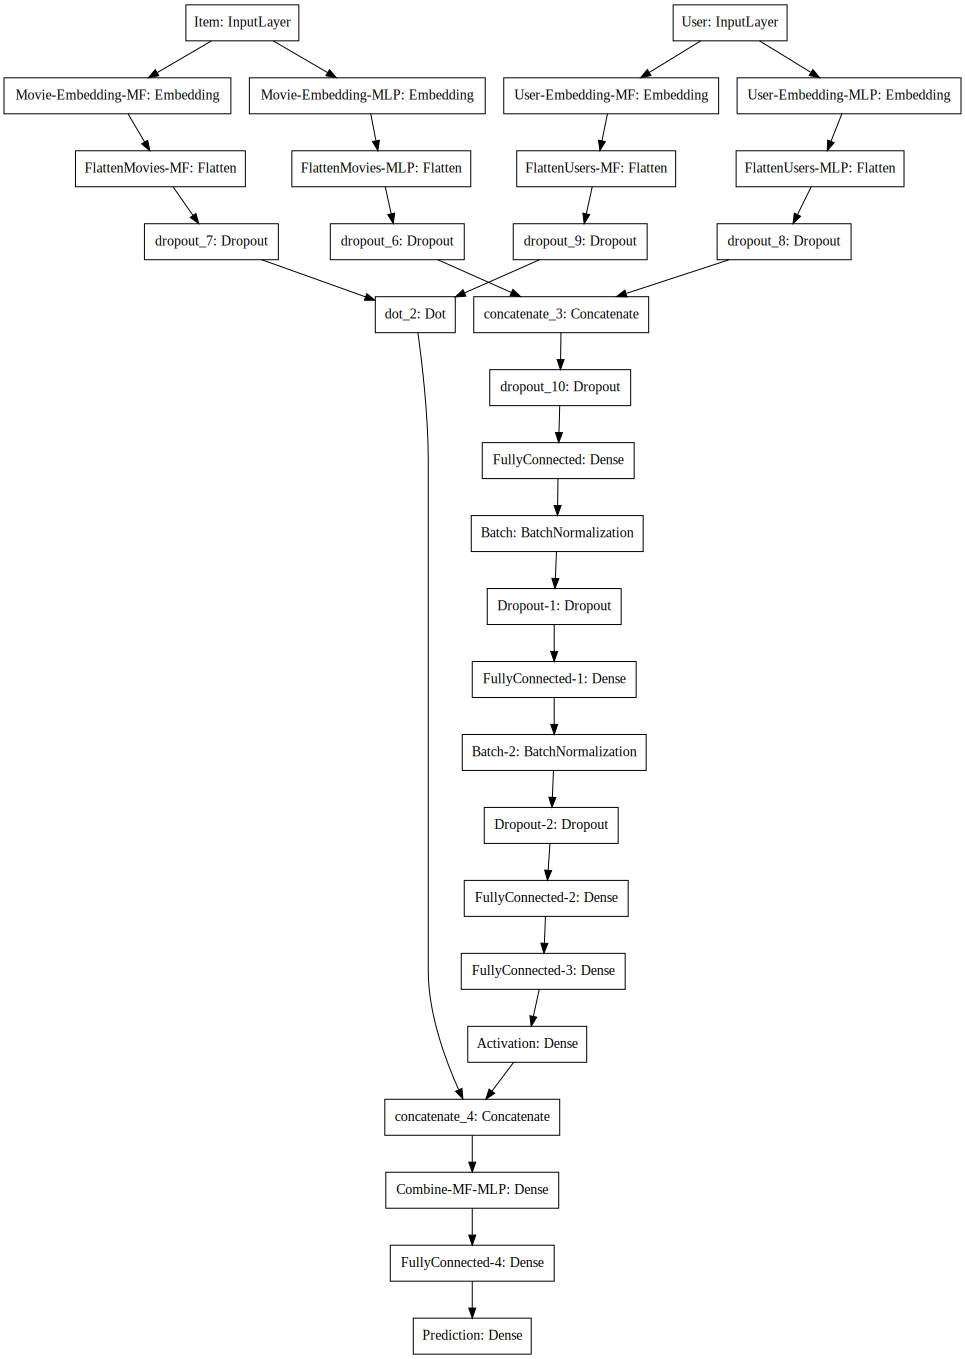

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding-MLP (Embedding) (None, 1, 10)        90720       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 8)         5392        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [0]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=25, verbose=0, validation_split=0.1)

In [15]:
from sklearn.metrics import mean_absolute_error
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.6843681263747251
0.6938993326042848


In [23]:
print(model.predict([test.user_id, test.item_id]))

[[2.9108   ]
 [4.10747  ]
 [2.8550944]
 ...
 [4.3609824]
 [3.2872348]
 [3.7673998]]


In [0]:
userId=1

In [28]:
ratingData = ratings[ratings['userId'] != userId]
uRatingData = ratings[ratings['userId'] == userId]
uMovieId = uRatingData['movieId']

movieId = ratingData['movieId']

movieId = movieId.loc[~movieId.isin(uMovieId)]


movieIndice = movieId.unique()

print(movieIndice)

moviesCF = newMoviesData.loc[newMoviesData['id'].isin(movieIndice)]
moviesCF.head(3)

[   10    17    39 ... 57158 19995 10054]


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,poster_path,tittle,cast,crew,imgURL,score,year,runtime_str,director
0,237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",https://image.tmdb.org/t/p/original/kmcqlZGaSh...,7.2,2009,2h42,James Cameron
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,/bXb00CkHqx7TPchTGG131sWV59y.jpg,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",https://image.tmdb.org/t/p/original/bXb00CkHqx...,6.9,2007,2h49,Gore Verbinski
5,258000000,"[Fantasy, Action, Adventure]",http://www.sonypictures.com/movies/spider-man3/,559,"[dual identity, amnesia, sandstorm]",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[Columbia Pictures, Laura Ziskin Productions, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,/sqZKCRYGovZ8aN99VVJSdL8Ja9k.jpg,Spider-Man 3,"[Tobey Maguire, Kirsten Dunst, James Franco]","[Francine Maisler, Joseph M. Caracciolo Jr., S...",https://image.tmdb.org/t/p/original/sqZKCRYGov...,5.9,2007,2h19,Sam Raimi


In [0]:
#moviesCF['id'].apply(lambda x: x)




In [0]:
#9072
moviesCF = moviesCF[moviesCF['id']<9072]
moviesCF['userId'] = userId
moviesCF
moviesCF['est'] = model.predict([moviesCF['userId'], moviesCF['id']])
moviesCF = moviesCF.sort_values('est', ascending=False)
    

In [65]:
returnColumns = ['id', 'title', 'imgURL','popularity', 'est']
CFResult = moviesCF[returnColumns].head(nRows)
CFResult

,id,title,imgURL,popularity,est
1,285,Pirates of the Caribbean: At World's End,https://image.tmdb.org/t/p/original/bXb00CkHqx...,139.082615,4.284945
2287,105,Back to the Future,https://image.tmdb.org/t/p/original/pTpxQB1N0w...,76.603233,4.280872
3680,1690,Hostel,https://image.tmdb.org/t/p/original/zF3pEs1CUb...,38.831920,4.234272
4792,692,Pink Flamingos,https://image.tmdb.org/t/p/original/oRNBSoftw8...,4.553644,4.230814
248,787,Mr. & Mrs. Smith,https://image.tmdb.org/t/p/original/dqs5BmwSUL...,44.635452,4.217545
4522,2056,The Station Agent,https://image.tmdb.org/t/p/original/kjJg6eJa9I...,11.578545,4.213127
929,6950,Outbreak,https://image.tmdb.org/t/p/original/4KymNvlWR0...,30.397496,4.165112
4742,473,Pi,https://image.tmdb.org/t/p/original/d4pDorUHjI...,27.788067,4.156427
1204,2044,The Lake House,https://image.tmdb.org/t/p/original/tHpc1118dY...,29.887360,4.134750
3633,3028,Jekyll and Hyde ... Together Again,https://image.tmdb.org/t/p/original/2FBX9zi9Na...,0.805312,4.107701


# References

https://arxiv.org/pdf/1707.07435.pdf

https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system#Collaborative-Filtering

https://nipunbatra.github.io/blog/2017/neural-collaborative-filtering.html